In [57]:
!pip install boto3 pandas matplotlib scikit-learn


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [58]:
import boto3

# Initialize the Bedrock client using default credentials from your environment
bedrock_client = boto3.client('bedrock-runtime')

In [59]:
import pandas as pd

# Sample customer query data
data = {
    "query": [
        "What is the current mortgage rate?",
        "I need help with my credit card payment",
        "Can I apply for a personal loan online?",
        "What are the fees for early mortgage repayment?",
        "How do I increase my credit card limit?"
    ]
}

df = pd.DataFrame(data)
print(df)

                                             query
0               What is the current mortgage rate?
1          I need help with my credit card payment
2          Can I apply for a personal loan online?
3  What are the fees for early mortgage repayment?
4          How do I increase my credit card limit?


In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Convert the text into TF-IDF features
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['query'])

# Use KMeans clustering to group similar queries
kmeans = KMeans(n_clusters=3, random_state=42).fit(X)
df['cluster'] = kmeans.labels_
print(df)

/Users/leetan/.local/share/virtualenvs/gpt-engineer-7XFB_0JR/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


                                             query  cluster
0               What is the current mortgage rate?        0
1          I need help with my credit card payment        1
2          Can I apply for a personal loan online?        2
3  What are the fees for early mortgage repayment?        0
4          How do I increase my credit card limit?        1


In [61]:
def classify_query(query):
    if 'mortgage' in query.lower():
        return 'Mortgage Inquiry'
    elif 'credit card' in query.lower():
        return 'Credit Card Inquiry'
    elif 'loan' in query.lower():
        return 'Loan Inquiry'
    else:
        return 'General Inquiry'

df['category'] = df['query'].apply(classify_query)
print(df)

                                             query  cluster  \
0               What is the current mortgage rate?        0   
1          I need help with my credit card payment        1   
2          Can I apply for a personal loan online?        2   
3  What are the fees for early mortgage repayment?        0   
4          How do I increase my credit card limit?        1   

              category  
0     Mortgage Inquiry  
1  Credit Card Inquiry  
2         Loan Inquiry  
3     Mortgage Inquiry  
4  Credit Card Inquiry  


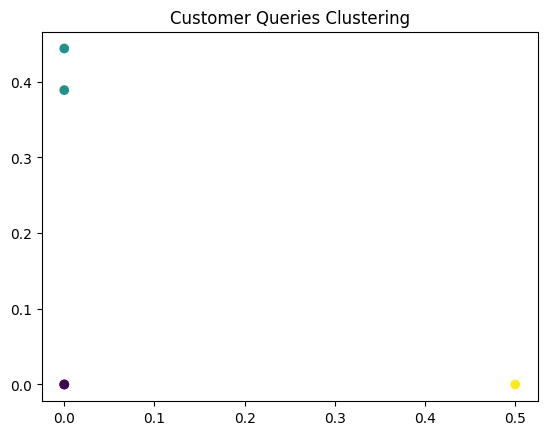

                                             query             category
0               What is the current mortgage rate?     Mortgage Inquiry
1          I need help with my credit card payment  Credit Card Inquiry
2          Can I apply for a personal loan online?         Loan Inquiry
3  What are the fees for early mortgage repayment?     Mortgage Inquiry
4          How do I increase my credit card limit?  Credit Card Inquiry


In [62]:
import matplotlib.pyplot as plt

# Visualizing the clusters
plt.scatter(X.toarray()[:, 0], X.toarray()[:, 1], c=df['cluster'])
plt.title("Customer Queries Clustering")
plt.show()

# Display the categorized results
print(df[['query', 'category']])

In [63]:
import json

# Create a properly formatted prompt, starting with "Human:" followed by the concatenated queries and ending with "Assistant:"
concatenated_queries = "\n".join([f"Human: {query}" for query in df['query'].tolist()])

# Add the "Assistant:" at the end to signal the model to respond
formatted_prompt = f"{concatenated_queries}\nAssistant:"

# Example of calling Bedrock for text processing with the correct conversational format
response = bedrock_client.invoke_model(
    modelId='anthropic.claude-v2',
    contentType='application/json',
    body=json.dumps({
        "prompt": formatted_prompt,    # The prompt now ends with "Assistant:"
        "max_tokens_to_sample": 100    # Specify a valid number of tokens to generate
    })
)

# Process the response for further classification or clustering
print(response)

{'ResponseMetadata': {'RequestId': 'dfb5d9b1-3ddd-414b-8f87-59cb3ab51d24', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Mon, 23 Sep 2024 18:29:18 GMT', 'content-type': 'application/json', 'content-length': '471', 'connection': 'keep-alive', 'x-amzn-requestid': 'dfb5d9b1-3ddd-414b-8f87-59cb3ab51d24', 'x-amzn-bedrock-invocation-latency': '2630', 'x-amzn-bedrock-output-token-count': '72', 'x-amzn-bedrock-input-token-count': '63'}, 'RetryAttempts': 0}, 'contentType': 'application/json', 'body': <botocore.response.StreamingBody object at 0x31eba99c0>}
